### 1. About the Dataset

The dataset that you are going to use is of **Detecting Hate Speech** in people's tweets.

#### Import Libraries

In [79]:
import pandas as pd
import re


import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#### Load the data set

In [80]:
tweet_data = pd.read_csv(
    r'C:\Users\Bint Hamza\Documents\Notebooks\Basic_ML_Model_for_Text_Classification\final_dataset_basicmlmodel.csv', 
    encoding='latin-1')
tweet_data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


#### Why to Preprocess text data?

As you may have already seen that without performing preprocessing operations like cleaning, removing stopwords and changing case in the dataset the representation always comes out wrong. In this case, it was that the wordcloud was full of noise but in other cases it might be your Machine Learning model that is going to suffer.

#### Steps involved in preprocessing of words
1. Tokenization
2. Normalization(Stemming or lemmatization)
3. Removing stop words
4. Vectorization

In [81]:
tweet_data.label.value_counts()

0    3000
1    2242
Name: label, dtype: int64

In [82]:
#read some tweet

for index, tweet in enumerate(tweet_data["tweet"][35:45]):
    print(index+1,".",tweet)

1 . when you finally finish a book you've been working on for awhile...  #bookworm #ontothenextnovel 
2 . yup, being a knicks fan is hard, so its easier to just be an nba fan when the playoffs roll around Ã°ÂÂÂ 
3 . there is life after social networking. embrace each day. be   
4 . my mom shares the same bihday as @user   bihday snake! see you this weekend Ã°ÂÂÂÃ°ÂÂÂ¼
5 . lovely echeveria blooms#flowers #grow #gardening #iphonesia #bliss #blooms #basilicabotanica   
6 . i am amazing. #i_am #positive #affirmation     
7 . #model   i love u take with u all the time in urÃ°ÂÂÂ±!!! Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂ¦Ã°ÂÂÂ¦Ã°ÂÂÂ¦  
8 . #whenever im   and #something goes #wrong  |  
9 . feeling blue #illustration   
10 . the best pa about life is knowing who you are! Ã°ÂÂÂÃ¢ÂÂÃ¯Â¸ÂÃ°ÂÂÂ¼Ã°ÂÂÂ»  Ã¢ÂÂ¦ 


In [83]:
!pip install wordcloud

In [84]:
### 2. Generating Word Frequency

#Let's first generate a frequency table of all the words present in all the tweets combined.

def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq[:20]
    
    return word_freq

#call the function
gen_freq(tweet_data.tweet.str)

@user       3284
the         1839
to          1486
a           1190
of           877
            ... 
vomit          1
#nzpol         1
#nyt           1
,,,            1
#d'banj.       1
Length: 18127, dtype: int64

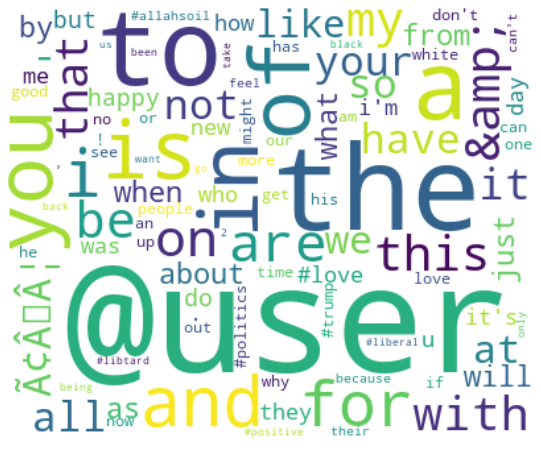

In [85]:
#visualize to see the words that have more noise

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, 
               background_color='white').generate_from_frequencies(gen_freq(tweet_data.tweet.str))

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

We can see the tweets contain a lot of non character and the words will need to be cleaned.

In [86]:
#Clean text from noise
def clean_text(text):
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Convert to lowercase to maintain consistency
    text = text.lower()
       
    return text

#call the function on the tweet
tweet_data['clean_text'] = tweet_data.tweet.apply(lambda x: clean_text(x))

tweet_data.head()

,id,label,tweet,clean_text
0,1,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can't us...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide society now motivation


In [87]:
#Import list of stopwords
from wordcloud import STOPWORDS

#Check whether a negation term is present in the text
def any_neg(words):
    for word in words:
        if word in ['n', 'no', 'non', 'not'] or re.search(r"\wn't", word):
            return 1
    else:
        return 0

#Check whether one of the 100 rare words is present in the text
def any_rare(words, rare_100):
    for word in words:
        if word in rare_100:
            return 1
    else:
        return 0

#Check whether prompt words are present
def is_question(words):
    for word in words:
        if word in ['when', 'what', 'how', 'why', 'who']:
            return 1
    else:
        return 0

In [88]:
word_freq = gen_freq(tweet_data.clean_text.str)
#100 most rare words in the dataset
rare_100 = word_freq[-100:]

#Number of words in a tweet
tweet_data['word_count'] = tweet_data.clean_text.str.split().apply(lambda x: len(x))
#Negation present or not
tweet_data['any_neg'] = tweet_data.clean_text.str.split().apply(lambda x: any_neg(x))
#Prompt present or not
tweet_data['is_question'] = tweet_data.clean_text.str.split().apply(lambda x: is_question(x))
#Any of the most 100 rare words present or not
tweet_data['any_rare'] = tweet_data.clean_text.str.split().apply(lambda x: any_rare(x, rare_100))
#Character count of the tweet
tweet_data['char_count'] = tweet_data.clean_text.apply(lambda x: len(x))

tweet_data.head()

,id,label,tweet,clean_text,word_count,any_neg,is_question,any_rare,char_count
0,1,0,@user when a father is dysfunctional and is s...,user when a father is dysfunctional and is s...,18,0,1,0,102
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i can't us...,19,1,0,0,122
2,3,0,bihday your majesty,bihday your majesty,3,0,0,1,21
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ...,12,0,0,0,118
4,5,0,factsguide: society now #motivation,factsguide society now motivation,4,0,0,0,39


In [89]:
#split the dataset into training and test set
from sklearn.model_selection import train_test_split

#we are trainig using the important features gotten from the data
X = tweet_data[['word_count', 'any_neg', 'any_rare', 'char_count', 'is_question']]
y = tweet_data.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=27)

In [90]:
from sklearn.naive_bayes import GaussianNB

#Initialize GaussianNB classifier
model = GaussianNB()
#Fit the model on the train dataset
model = model.fit(X_train, y_train)
#Make predictions on the test dataset
pred = model.predict(X_test)

In [91]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, pred)*100, "%")

Accuracy: 60.38095238095238 %


In [92]:
from sklearn.metrics import confusion_matrix

cg = confusion_matrix(y_test, pred)
cg

array([[256,  54],
       [154,  61]], dtype=int64)

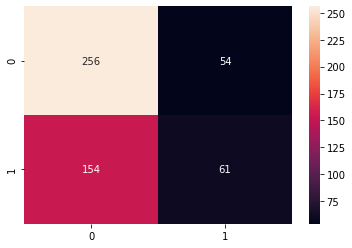

In [93]:
import seaborn as sns

sns.heatmap(cg, annot = True, fmt= 'g')

### Building the Model based on the text 

In [94]:
#import the vectorizer
from sklearn.feature_extraction.text import CountVectorizer 

In [95]:
#split the text into train and test

X= tweet_data['clean_text']
y = tweet_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1111)

In [96]:
vectorizer = CountVectorizer()

text_countVect = vectorizer.fit(X_train)

print("Vocabulary: ", text_countVect.vocabulary_)

Vocabulary:  {'picture': 6264, 'is': 4281, 'woh': 9226, 'thousand': 8371, 'words': 9258, 'sundayrewind': 8026, 'hongkong': 3882, 'travel': 8545, 'lady': 4621, 'lawyer': 4690, 'afterpas': 143, 'made': 5015, 'in': 4088, 'japan': 4351, 'madeinjapan': 5016, 'eos': 2701, 'cute': 2009, 'fun': 3297, 'cawaii': 1380, 'love': 4934, 'strawberry': 7941, 'tomato': 8462, 'user': 8808, 'so': 7687, 'what': 9102, 'jewish': 4385, 'kwanza': 4606, 'jehovas': 4372, 'witness': 9218, 'bigot': 849, 'sea': 7306, 'shepherd': 7455, 'suppoers': 8050, 'are': 436, 'racist': 6722, 'antiracism': 365, 'seashepherd': 7311, 'no': 5718, 'ice': 3986, 'cream': 1918, 'comes': 1673, 'close': 1598, 'to': 8441, 'the': 8287, 'goodness': 3482, 'that': 8283, 'kilwin': 4542, 'have': 3714, 'dreams': 2461, 'about': 20, 'once': 5913, 'month': 5405, 'wonderful': 9246, 'photo': 6244, 'like': 4810, 'spontaneity': 7802, 'of': 5858, 'expressions': 2849, 'allahsoil': 223, 'enlightenment': 2682, 'wasted': 9007, 'on': 5911, 'wilfully': 9176,

In [97]:
#transform the data
train_vec = vectorizer.transform(X_train)

test_vec = vectorizer.transform(X_test)

In [98]:
#build model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB() 
mnb.fit(train_vec, y_train)

MultinomialNB()

In [99]:
#Make predictions on the test dataset
preds = mnb.predict(test_vec)

from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, preds)*100, "%")

Accuracy: 86.96757787666878 %


In [100]:
from sklearn.metrics import confusion_matrix

cm= confusion_matrix(y_test, preds)
cm

array([[792, 111],
       [ 94, 576]], dtype=int64)

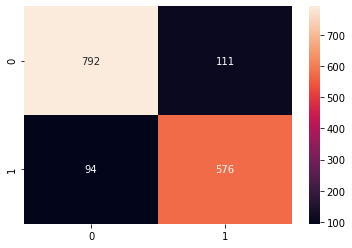

In [101]:
import seaborn as sns

sns.heatmap(cm, annot = True, fmt= 'g')

Using the text directly after vectorization seems to work better than creating features from the text and then modelling on it.

In [105]:
#write functions to detect if the message is spam or not
def find(x):
    if x == 1:
        print ("Hate Speech")
    else:
        print ("Normal Speech")

In [106]:
newtext = ["I still dont understand some important concept, need to study more"]
integers = vectorizer.transform(newtext)

In [107]:
x = mnb.predict(integers)
find(x)


Normal Speech


In [120]:
newtext2 = ["There are so many misogynistic things happening, Fuck the system!, THing about to go awry"]
integers1 = vectorizer.transform(newtext2)

In [121]:
h = mnb.predict(integers1)
find(h)


Hate Speech
